In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [15]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
#         dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - rho * torch.log(self.data_rho) - (1 - rho) * torch.log(1 - self.data_rho)
#         maxInd = torch.argmax(self.data_rho)
#         print(maxInd, dkl)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [16]:
models = {'16': Net(16).to(device), '32': Net(32).to(device), '64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [17]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data.to(device))
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data.to(device)) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [18]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
data_rho_lambda = lambda q: 'data_rho: {}'.format(q)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
line_extra = lambda i, l, p, q: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p) + '\n' + data_rho_lambda(q)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data.to(device)) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data.to(device), reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k], models[k].data_rho))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [19]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

tensor(14, device='cuda:0') tensor([0.8036, 0.5429, 0.8577, 0.9840, 0.9933, 0.5353, 0.6551, 0.7328, 0.6423,
        0.6526, 0.7519, 0.3981, 0.4296, 0.5095, 1.0685, 0.4494],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(26, device='cuda:0') tensor([0.8618, 0.8890, 0.4595, 0.7133, 0.4701, 0.7653, 0.6300, 0.7559, 0.4403,
        0.6709, 0.7304, 0.9103, 0.6315, 1.0427, 0.9756, 0.5220, 0.6363, 0.6927,
        0.9968, 0.8036, 0.5042, 0.5409, 0.5223, 0.5571, 0.4497, 0.7079, 1.1254,
        0.6055, 0.6010, 0.5507, 0.5755, 0.9679],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(60, device='cuda:0') tensor([0.5952, 0.5166, 0.5594, 0.3313, 0.6390, 0.9707, 0.4756, 0.8478, 1.1168,
        0.8871, 0.9471, 0.6049, 0.5830, 0.4914, 0.6559, 0.7713, 0.7210, 0.7169,
        0.8568, 0.8515, 0.8415, 0.6639, 0.6680, 0.8486, 0.7226, 0.4760, 0.9394,
        0.5501, 0.6101, 0.6526, 0.4811, 0.6534, 0.5716, 0.4470, 0.5981, 0.9640,
        0.8575, 0.9766, 0.6802, 0.5998, 0.8155, 0.5741, 0.6114, 

tensor(14, device='cuda:0') tensor([0.3359, 0.2538, 0.3626, 0.4194, 0.4412, 0.2493, 0.2925, 0.3245, 0.2875,
        0.2824, 0.3428, 0.2310, 0.2270, 0.2542, 0.4777, 0.2327],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(13, device='cuda:0') tensor([0.3777, 0.3661, 0.2354, 0.2924, 0.2365, 0.3453, 0.2826, 0.3181, 0.2299,
        0.3068, 0.3169, 0.4067, 0.2763, 0.4729, 0.4252, 0.2558, 0.2976, 0.3042,
        0.4261, 0.3560, 0.2567, 0.2628, 0.2570, 0.2665, 0.2350, 0.3064, 0.4590,
        0.2922, 0.2586, 0.2660, 0.2640, 0.4108],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(60, device='cuda:0') tensor([0.2787, 0.2506, 0.2701, 0.2053, 0.2953, 0.3948, 0.2418, 0.3650, 0.4880,
        0.3649, 0.3927, 0.2675, 0.2733, 0.2431, 0.2727, 0.3274, 0.3232, 0.3280,
        0.3523, 0.3669, 0.3732, 0.2986, 0.2857, 0.3654, 0.3148, 0.2296, 0.3937,
        0.2635, 0.2807, 0.2947, 0.2419, 0.2870, 0.2788, 0.2304, 0.2737, 0.4059,
        0.3509, 0.4320, 0.3270, 0.2996, 0.3576, 0.2721, 0.2860, 

tensor(14, device='cuda:0') tensor([0.2257, 0.2046, 0.2407, 0.2666, 0.2559, 0.2067, 0.2116, 0.2245, 0.2122,
        0.2176, 0.2284, 0.2011, 0.2002, 0.2034, 0.2677, 0.2014],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(26, device='cuda:0') tensor([0.2354, 0.2358, 0.2029, 0.2238, 0.2051, 0.2323, 0.2255, 0.2267, 0.2028,
        0.2291, 0.2219, 0.2508, 0.2083, 0.2597, 0.2582, 0.2069, 0.2180, 0.2212,
        0.2605, 0.2320, 0.2131, 0.2077, 0.2047, 0.2115, 0.2059, 0.2289, 0.2700,
        0.2190, 0.2086, 0.2101, 0.2131, 0.2673],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(60, device='cuda:0') tensor([0.2336, 0.2071, 0.2108, 0.1985, 0.2275, 0.2545, 0.2050, 0.2643, 0.2847,
        0.2492, 0.2500, 0.2081, 0.2230, 0.2022, 0.2138, 0.2377, 0.2340, 0.2394,
        0.2423, 0.2331, 0.2495, 0.2221, 0.2209, 0.2376, 0.2296, 0.2018, 0.2490,
        0.2095, 0.2181, 0.2448, 0.2073, 0.2171, 0.2367, 0.2064, 0.2153, 0.2438,
        0.2306, 0.2725, 0.2237, 0.2432, 0.2363, 0.2128, 0.2210, 

tensor(39, device='cuda:0') tensor([0.2388, 0.2010, 0.2037, 0.1989, 0.2203, 0.2289, 0.1992, 0.2294, 0.2385,
        0.2237, 0.2142, 0.2016, 0.2203, 0.1996, 0.2037, 0.2172, 0.2097, 0.2185,
        0.2136, 0.2114, 0.2271, 0.2039, 0.2093, 0.2129, 0.2097, 0.1985, 0.2226,
        0.2032, 0.2086, 0.2524, 0.2049, 0.2061, 0.2382, 0.2048, 0.2030, 0.2221,
        0.2126, 0.2380, 0.2102, 0.2594, 0.2123, 0.2041, 0.2081, 0.2107, 0.2189,
        0.2293, 0.2304, 0.2034, 0.2123, 0.2230, 0.2199, 0.2105, 0.2108, 0.2119,
        0.2164, 0.2131, 0.2230, 0.2200, 0.2146, 0.1986, 0.2556, 0.2258, 0.2218,
        0.2179], device='cuda:0', grad_fn=<ThSubBackward>)
tensor(14, device='cuda:0') tensor([0.2048, 0.2003, 0.2172, 0.2156, 0.2216, 0.2017, 0.2019, 0.2122, 0.2016,
        0.2045, 0.2083, 0.2003, 0.1985, 0.1997, 0.2229, 0.1986],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(18, device='cuda:0') tensor([0.2128, 0.2158, 0.2003, 0.2046, 0.1992, 0.2093, 0.2184, 0.2093, 0.2000,
        0.2129, 0.2053,

tensor(31, device='cuda:0') tensor([0.2025, 0.2074, 0.2007, 0.1996, 0.1987, 0.2009, 0.2154, 0.2024, 0.1992,
        0.2045, 0.2005, 0.2081, 0.1988, 0.2064, 0.2138, 0.1994, 0.2009, 0.1995,
        0.2152, 0.1996, 0.2057, 0.1992, 0.1987, 0.1996, 0.2012, 0.2075, 0.2085,
        0.2029, 0.1985, 0.2013, 0.1999, 0.2167],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(39, device='cuda:0') tensor([0.2628, 0.2007, 0.2017, 0.1990, 0.2299, 0.2209, 0.1989, 0.2164, 0.2157,
        0.2145, 0.2046, 0.1995, 0.2278, 0.1985, 0.2002, 0.2090, 0.2039, 0.2120,
        0.2008, 0.2064, 0.2165, 0.1998, 0.2045, 0.2017, 0.2056, 0.1989, 0.2091,
        0.2005, 0.2065, 0.2839, 0.2012, 0.2005, 0.2696, 0.2086, 0.1998, 0.2122,
        0.2027, 0.2205, 0.2015, 0.2960, 0.2047, 0.2024, 0.2050, 0.2050, 0.2136,
        0.2228, 0.2244, 0.1991, 0.2031, 0.2292, 0.2090, 0.2042, 0.2008, 0.2048,
        0.2203, 0.2094, 0.2138, 0.2102, 0.2124, 0.2003, 0.2194, 0.2159, 0.2131,
        0.2050], device='cuda:0', grad_fn=<ThS

tensor(14, device='cuda:0') tensor([0.1997, 0.1986, 0.2033, 0.1994, 0.2038, 0.2002, 0.1989, 0.2052, 0.1985,
        0.2003, 0.1999, 0.2013, 0.1985, 0.1992, 0.2056, 0.1986],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2042, 0.2062, 0.2046, 0.2024, 0.1990, 0.2027, 0.2303, 0.2023, 0.2005,
        0.2061, 0.2021, 0.2080, 0.2003, 0.2040, 0.2097, 0.2008, 0.2003, 0.1994,
        0.2195, 0.1986, 0.2088, 0.1996, 0.1986, 0.2012, 0.2030, 0.2087, 0.2050,
        0.2051, 0.1985, 0.2054, 0.2002, 0.2171],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(39, device='cuda:0') tensor([0.3494, 0.2014, 0.2059, 0.1987, 0.2370, 0.2270, 0.2011, 0.2261, 0.2183,
        0.2217, 0.2053, 0.2000, 0.2652, 0.2002, 0.2020, 0.2118, 0.2042, 0.2186,
        0.2013, 0.2041, 0.2239, 0.2008, 0.2116, 0.2036, 0.2063, 0.1985, 0.2112,
        0.2025, 0.2135, 0.3752, 0.2129, 0.2025, 0.3430, 0.2207, 0.2004, 0.2104,
        0.2041, 0.2262, 0.2050, 0.4136, 0.2079, 0.2053, 0.2061, 0

tensor(7, device='cuda:0') tensor([0.1996, 0.1997, 0.2040, 0.2011, 0.1998, 0.2016, 0.1991, 0.2065, 0.1988,
        0.1995, 0.2007, 0.2015, 0.1988, 0.1990, 0.2042, 0.1996],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2021, 0.2080, 0.2067, 0.2017, 0.2000, 0.2021, 0.2392, 0.2019, 0.2034,
        0.2064, 0.2016, 0.2048, 0.2007, 0.2026, 0.2105, 0.2024, 0.2030, 0.1997,
        0.2182, 0.1986, 0.2144, 0.2014, 0.1985, 0.2026, 0.2087, 0.2225, 0.2047,
        0.2117, 0.1985, 0.2082, 0.2035, 0.2203],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(39, device='cuda:0') tensor([0.4396, 0.2082, 0.2085, 0.1999, 0.2821, 0.2380, 0.2032, 0.2487, 0.2141,
        0.2252, 0.2025, 0.2014, 0.3189, 0.2004, 0.2028, 0.2192, 0.2083, 0.2318,
        0.2038, 0.2060, 0.2273, 0.2002, 0.2157, 0.2024, 0.2076, 0.1990, 0.2071,
        0.2064, 0.2177, 0.4730, 0.2302, 0.2070, 0.4379, 0.2581, 0.2042, 0.2101,
        0.2059, 0.2334, 0.2038, 0.5190, 0.2107, 0.2101, 0.2115, 0.

tensor(7, device='cuda:0') tensor([0.1992, 0.1992, 0.2045, 0.2004, 0.2008, 0.2018, 0.1991, 0.2093, 0.1985,
        0.2001, 0.1991, 0.2030, 0.1986, 0.1990, 0.2022, 0.1989],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2017, 0.2039, 0.2118, 0.2014, 0.2005, 0.2032, 0.2561, 0.2022, 0.2034,
        0.2113, 0.2029, 0.2044, 0.2011, 0.2012, 0.2094, 0.2019, 0.2053, 0.1996,
        0.2170, 0.1986, 0.2249, 0.2008, 0.1985, 0.2024, 0.2109, 0.2273, 0.2034,
        0.2130, 0.1986, 0.2107, 0.2035, 0.2218],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(39, device='cuda:0') tensor([0.5498, 0.2086, 0.2139, 0.2021, 0.3204, 0.2403, 0.2052, 0.2663, 0.2155,
        0.2325, 0.2016, 0.2033, 0.4045, 0.2014, 0.2043, 0.2314, 0.2092, 0.2485,
        0.2051, 0.2046, 0.2413, 0.2015, 0.2241, 0.2016, 0.2115, 0.1987, 0.2096,
        0.2105, 0.2345, 0.5717, 0.2613, 0.2097, 0.5434, 0.3060, 0.2047, 0.2098,
        0.2059, 0.2479, 0.2065, 0.6265, 0.2132, 0.2179, 0.2186, 0.

tensor(7, device='cuda:0') tensor([0.1993, 0.1995, 0.2040, 0.1992, 0.1999, 0.2021, 0.1988, 0.2116, 0.1985,
        0.2001, 0.2000, 0.2030, 0.1988, 0.1998, 0.2028, 0.1990],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2019, 0.2101, 0.2176, 0.2039, 0.2010, 0.2020, 0.2755, 0.2045, 0.2079,
        0.2110, 0.2052, 0.2052, 0.2032, 0.2020, 0.2086, 0.2061, 0.2067, 0.1992,
        0.2177, 0.1986, 0.2303, 0.2026, 0.1988, 0.2043, 0.2181, 0.2415, 0.2037,
        0.2215, 0.1986, 0.2160, 0.2059, 0.2250],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(39, device='cuda:0') tensor([0.5929, 0.2159, 0.2193, 0.2095, 0.3714, 0.2617, 0.2076, 0.2785, 0.2108,
        0.2405, 0.2018, 0.2051, 0.4686, 0.2059, 0.2094, 0.2394, 0.2112, 0.2635,
        0.2040, 0.2069, 0.2510, 0.2029, 0.2467, 0.2004, 0.2172, 0.2004, 0.2056,
        0.2125, 0.2464, 0.6503, 0.2983, 0.2162, 0.6001, 0.3865, 0.2099, 0.2150,
        0.2066, 0.2573, 0.2115, 0.6764, 0.2205, 0.2318, 0.2264, 0.

tensor(29, device='cuda:0') tensor([0.6580, 0.2254, 0.2339, 0.2117, 0.4666, 0.2732, 0.2129, 0.3055, 0.2136,
        0.2378, 0.1997, 0.2063, 0.5525, 0.2062, 0.2078, 0.2543, 0.2118, 0.2802,
        0.2025, 0.2052, 0.2715, 0.2037, 0.2504, 0.1988, 0.2221, 0.2013, 0.2064,
        0.2122, 0.2571, 0.7020, 0.3554, 0.2148, 0.6499, 0.4778, 0.2186, 0.2096,
        0.2018, 0.2734, 0.2111, 0.6926, 0.2284, 0.2442, 0.2397, 0.2049, 0.2662,
        0.3273, 0.3176, 0.2050, 0.2021, 0.5801, 0.2230, 0.2347, 0.2171, 0.3133,
        0.5002, 0.2932, 0.2315, 0.2090, 0.3518, 0.1998, 0.2181, 0.2351, 0.2362,
        0.1989], device='cuda:0', grad_fn=<ThSubBackward>)
tensor(7, device='cuda:0') tensor([0.1986, 0.1989, 0.2025, 0.1986, 0.1994, 0.2026, 0.1986, 0.2053, 0.1985,
        0.1999, 0.1987, 0.2051, 0.1985, 0.1994, 0.2015, 0.1990],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2016, 0.2087, 0.2261, 0.2015, 0.2000, 0.2024, 0.3001, 0.2055, 0.2142,
        0.2122, 0.2027, 0

tensor(7, device='cuda:0') tensor([0.1989, 0.1994, 0.2047, 0.1985, 0.2010, 0.2043, 0.1986, 0.2101, 0.1987,
        0.2003, 0.1995, 0.2085, 0.1986, 0.1997, 0.2015, 0.1992],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2034, 0.2126, 0.2433, 0.2033, 0.2037, 0.2042, 0.3511, 0.2088, 0.2262,
        0.2214, 0.2081, 0.2073, 0.2050, 0.2007, 0.2178, 0.2125, 0.2097, 0.2007,
        0.2224, 0.1988, 0.2707, 0.2068, 0.1992, 0.2143, 0.2461, 0.2481, 0.2014,
        0.2368, 0.1989, 0.2355, 0.2122, 0.2391],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(29, device='cuda:0') tensor([0.7013, 0.2412, 0.2489, 0.2439, 0.4562, 0.2778, 0.2195, 0.3064, 0.2128,
        0.2512, 0.2018, 0.2134, 0.5641, 0.2130, 0.2142, 0.2670, 0.2162, 0.2981,
        0.2014, 0.2095, 0.2906, 0.2052, 0.2730, 0.2010, 0.2274, 0.2037, 0.2133,
        0.2206, 0.2810, 0.7090, 0.4001, 0.2197, 0.6483, 0.5334, 0.2186, 0.2168,
        0.2076, 0.2877, 0.2155, 0.6870, 0.2369, 0.2620, 0.2541, 0.

tensor(0, device='cuda:0') tensor([0.8175, 0.2521, 0.2507, 0.2575, 0.5603, 0.2863, 0.2272, 0.3228, 0.2129,
        0.2520, 0.2006, 0.2155, 0.6391, 0.2139, 0.2122, 0.2832, 0.2222, 0.3150,
        0.2009, 0.2108, 0.2957, 0.2048, 0.2831, 0.1999, 0.2410, 0.2054, 0.2074,
        0.2245, 0.3080, 0.7527, 0.4551, 0.2271, 0.7134, 0.5953, 0.2302, 0.2103,
        0.2045, 0.2900, 0.2175, 0.7529, 0.2310, 0.2887, 0.2699, 0.2101, 0.3072,
        0.3908, 0.3325, 0.2109, 0.2069, 0.6373, 0.2386, 0.2536, 0.2311, 0.4054,
        0.6040, 0.3402, 0.2454, 0.2152, 0.4416, 0.2020, 0.2164, 0.2393, 0.2366,
        0.1990], device='cuda:0', grad_fn=<ThSubBackward>)
tensor(7, device='cuda:0') tensor([0.1988, 0.2001, 0.2030, 0.1986, 0.1989, 0.2083, 0.1987, 0.2108, 0.1985,
        0.2008, 0.1989, 0.2062, 0.1989, 0.2003, 0.2013, 0.1998],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2037, 0.2144, 0.2616, 0.2064, 0.2052, 0.2030, 0.4034, 0.2075, 0.2356,
        0.2311, 0.2066, 0.

tensor(6, device='cuda:0') tensor([0.2068, 0.2231, 0.2979, 0.2102, 0.2190, 0.2073, 0.4240, 0.2107, 0.2641,
        0.2319, 0.2110, 0.2109, 0.2114, 0.2014, 0.2223, 0.2221, 0.2189, 0.2032,
        0.2364, 0.1987, 0.3557, 0.2184, 0.2002, 0.2230, 0.3227, 0.3077, 0.2030,
        0.2711, 0.1989, 0.2803, 0.2316, 0.2578],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(29, device='cuda:0') tensor([0.6794, 0.2584, 0.2676, 0.2977, 0.5486, 0.2974, 0.2328, 0.3487, 0.2207,
        0.2532, 0.2008, 0.2222, 0.6562, 0.2290, 0.2228, 0.2796, 0.2266, 0.3598,
        0.2062, 0.2170, 0.3142, 0.2082, 0.3128, 0.2027, 0.2397, 0.2120, 0.2115,
        0.2378, 0.3340, 0.7575, 0.4818, 0.2429, 0.7458, 0.6424, 0.2404, 0.2172,
        0.2125, 0.3128, 0.2184, 0.7351, 0.2366, 0.3063, 0.2773, 0.2093, 0.3099,
        0.4114, 0.3396, 0.2217, 0.2096, 0.6599, 0.2419, 0.2732, 0.2389, 0.4391,
        0.5949, 0.3842, 0.2450, 0.2190, 0.4573, 0.2046, 0.2271, 0.2419, 0.2428,
        0.2001], device='cuda:0', grad_fn=<ThSu

tensor(11, device='cuda:0') tensor([0.2010, 0.2008, 0.2065, 0.1988, 0.2032, 0.2088, 0.2005, 0.2193, 0.1985,
        0.2048, 0.2007, 0.2198, 0.1995, 0.2037, 0.2013, 0.2014],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2085, 0.2261, 0.3432, 0.2131, 0.2203, 0.2105, 0.4594, 0.2146, 0.2870,
        0.2411, 0.2176, 0.2121, 0.2142, 0.2034, 0.2224, 0.2386, 0.2216, 0.2024,
        0.2422, 0.1985, 0.3791, 0.2192, 0.2035, 0.2373, 0.3471, 0.3230, 0.2026,
        0.3028, 0.1996, 0.2932, 0.2468, 0.2608],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(29, device='cuda:0') tensor([0.6778, 0.2702, 0.2835, 0.3421, 0.5406, 0.3086, 0.2446, 0.3445, 0.2193,
        0.2698, 0.2010, 0.2240, 0.6029, 0.2396, 0.2208, 0.2985, 0.2296, 0.3374,
        0.2071, 0.2171, 0.3125, 0.2125, 0.3154, 0.2019, 0.2453, 0.2100, 0.2128,
        0.2405, 0.3460, 0.7074, 0.4842, 0.2423, 0.6613, 0.5990, 0.2429, 0.2161,
        0.2102, 0.3192, 0.2235, 0.6880, 0.2486, 0.3361, 0.2821, 0

tensor(11, device='cuda:0') tensor([0.1994, 0.2016, 0.2112, 0.1986, 0.2004, 0.2141, 0.2002, 0.2201, 0.1987,
        0.2027, 0.2005, 0.2277, 0.2002, 0.2051, 0.2022, 0.2049],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2078, 0.2265, 0.3842, 0.2150, 0.2365, 0.2102, 0.5146, 0.2196, 0.3126,
        0.2618, 0.2199, 0.2136, 0.2208, 0.2039, 0.2383, 0.2488, 0.2321, 0.2046,
        0.2543, 0.1986, 0.4154, 0.2297, 0.2020, 0.2410, 0.4074, 0.3571, 0.2023,
        0.3158, 0.2009, 0.3376, 0.2571, 0.2901],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(39, device='cuda:0') tensor([0.7026, 0.2896, 0.2942, 0.3764, 0.5620, 0.2932, 0.2433, 0.3447, 0.2172,
        0.2600, 0.1997, 0.2280, 0.6250, 0.2386, 0.2213, 0.2977, 0.2243, 0.3505,
        0.2059, 0.2146, 0.3209, 0.2136, 0.3306, 0.2027, 0.2460, 0.2156, 0.2106,
        0.2401, 0.3624, 0.6860, 0.5465, 0.2475, 0.6705, 0.6658, 0.2486, 0.2145,
        0.2107, 0.3116, 0.2238, 0.7136, 0.2443, 0.3384, 0.2948, 0

tensor(29, device='cuda:0') tensor([0.6365, 0.2970, 0.2890, 0.4170, 0.5262, 0.3174, 0.2400, 0.3663, 0.2174,
        0.2873, 0.2040, 0.2302, 0.5966, 0.2473, 0.2348, 0.2908, 0.2290, 0.3521,
        0.2097, 0.2199, 0.3132, 0.2124, 0.3375, 0.2040, 0.2536, 0.2194, 0.2134,
        0.2594, 0.3714, 0.6936, 0.4932, 0.2532, 0.6637, 0.6377, 0.2503, 0.2161,
        0.2155, 0.3180, 0.2203, 0.6733, 0.2454, 0.3376, 0.2994, 0.2175, 0.3394,
        0.4107, 0.3549, 0.2362, 0.2156, 0.6511, 0.2518, 0.2930, 0.2484, 0.4683,
        0.5686, 0.4023, 0.2506, 0.2229, 0.4820, 0.2148, 0.2241, 0.2394, 0.2512,
        0.2017], device='cuda:0', grad_fn=<ThSubBackward>)
tensor(11, device='cuda:0') tensor([0.2010, 0.2025, 0.2098, 0.1988, 0.1998, 0.2174, 0.2013, 0.2230, 0.1995,
        0.2055, 0.2001, 0.2303, 0.2028, 0.2091, 0.2020, 0.2037],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2136, 0.2391, 0.4220, 0.2201, 0.2305, 0.2144, 0.5285, 0.2202, 0.3560,
        0.2798, 0.2250, 

tensor(0, device='cuda:0') tensor([0.6964, 0.3037, 0.2936, 0.4256, 0.5403, 0.3075, 0.2532, 0.3499, 0.2130,
        0.2681, 0.2030, 0.2357, 0.6017, 0.2425, 0.2264, 0.3034, 0.2253, 0.3589,
        0.2045, 0.2197, 0.3234, 0.2179, 0.3339, 0.2011, 0.2604, 0.2173, 0.2095,
        0.2484, 0.3755, 0.6718, 0.5286, 0.2472, 0.6545, 0.6092, 0.2631, 0.2154,
        0.2080, 0.3054, 0.2241, 0.6625, 0.2402, 0.3476, 0.3121, 0.2164, 0.3194,
        0.3985, 0.3608, 0.2271, 0.2157, 0.6261, 0.2496, 0.2899, 0.2423, 0.4800,
        0.5770, 0.4079, 0.2572, 0.2238, 0.4949, 0.2140, 0.2146, 0.2411, 0.2534,
        0.1997], device='cuda:0', grad_fn=<ThSubBackward>)
tensor(11, device='cuda:0') tensor([0.2007, 0.2054, 0.2122, 0.1990, 0.2008, 0.2264, 0.2008, 0.2314, 0.1989,
        0.2061, 0.2014, 0.2384, 0.2027, 0.2069, 0.2047, 0.2097],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2099, 0.2432, 0.4191, 0.2203, 0.2549, 0.2167, 0.5238, 0.2279, 0.3621,
        0.2813, 0.2285, 0

tensor(6, device='cuda:0') tensor([0.2132, 0.2491, 0.4254, 0.2288, 0.2578, 0.2190, 0.5079, 0.2307, 0.3749,
        0.2806, 0.2393, 0.2130, 0.2465, 0.2030, 0.2388, 0.2993, 0.2499, 0.2068,
        0.2664, 0.1990, 0.4397, 0.2565, 0.2075, 0.2840, 0.4222, 0.3853, 0.2067,
        0.3735, 0.2053, 0.3817, 0.2993, 0.2954],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(29, device='cuda:0') tensor([0.5855, 0.3195, 0.3079, 0.4213, 0.4677, 0.3432, 0.2684, 0.3218, 0.2118,
        0.2824, 0.2061, 0.2407, 0.5144, 0.2486, 0.2308, 0.3264, 0.2214, 0.3204,
        0.2060, 0.2223, 0.3218, 0.2156, 0.3315, 0.2013, 0.2495, 0.2329, 0.2128,
        0.2543, 0.3444, 0.6578, 0.5246, 0.2542, 0.4891, 0.5476, 0.2428, 0.2139,
        0.2145, 0.3036, 0.2231, 0.5833, 0.2369, 0.3340, 0.2808, 0.2215, 0.3147,
        0.3782, 0.3490, 0.2365, 0.2133, 0.6189, 0.2667, 0.2854, 0.2384, 0.5476,
        0.4930, 0.4101, 0.2592, 0.2294, 0.4454, 0.2145, 0.2150, 0.2336, 0.2501,
        0.2010], device='cuda:0', grad_fn=<ThSu

tensor(29, device='cuda:0') tensor([0.5821, 0.3371, 0.2893, 0.4263, 0.4662, 0.3252, 0.2670, 0.3505, 0.2092,
        0.2715, 0.2065, 0.2398, 0.5520, 0.2548, 0.2281, 0.3327, 0.2266, 0.3537,
        0.2115, 0.2199, 0.3197, 0.2160, 0.3432, 0.2015, 0.2607, 0.2449, 0.2116,
        0.2622, 0.3814, 0.6379, 0.5744, 0.2545, 0.5651, 0.5592, 0.2534, 0.2138,
        0.2147, 0.3049, 0.2240, 0.5615, 0.2354, 0.3640, 0.2980, 0.2178, 0.3443,
        0.3785, 0.3365, 0.2417, 0.2193, 0.6370, 0.2542, 0.2844, 0.2442, 0.5333,
        0.5210, 0.4212, 0.2541, 0.2284, 0.4686, 0.2154, 0.2157, 0.2323, 0.2512,
        0.2011], device='cuda:0', grad_fn=<ThSubBackward>)
tensor(11, device='cuda:0') tensor([0.2030, 0.2084, 0.2132, 0.1989, 0.2015, 0.2443, 0.2019, 0.2524, 0.1990,
        0.2115, 0.2027, 0.2767, 0.2064, 0.2101, 0.2050, 0.2153],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2126, 0.2580, 0.4816, 0.2302, 0.2871, 0.2174, 0.5706, 0.2342, 0.4261,
        0.3039, 0.2353, 

tensor(6, device='cuda:0') tensor([0.2133, 0.2497, 0.5295, 0.2343, 0.2879, 0.2212, 0.5941, 0.2319, 0.4689,
        0.3243, 0.2386, 0.2170, 0.2528, 0.2051, 0.2533, 0.3044, 0.2666, 0.2075,
        0.2857, 0.1988, 0.5503, 0.2784, 0.2064, 0.2913, 0.5137, 0.4400, 0.2059,
        0.4101, 0.2031, 0.4720, 0.3351, 0.3171],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(0, device='cuda:0') tensor([0.6866, 0.3192, 0.2961, 0.5139, 0.5396, 0.2889, 0.2610, 0.3463, 0.2157,
        0.2602, 0.1997, 0.2398, 0.6149, 0.2539, 0.2253, 0.2954, 0.2330, 0.3678,
        0.2071, 0.2170, 0.3109, 0.2118, 0.3423, 0.2010, 0.2518, 0.2245, 0.2088,
        0.2619, 0.3932, 0.6779, 0.5498, 0.2502, 0.6770, 0.6197, 0.2710, 0.2129,
        0.2080, 0.3023, 0.2200, 0.6179, 0.2410, 0.3788, 0.3227, 0.2154, 0.3348,
        0.4151, 0.3285, 0.2360, 0.2105, 0.6235, 0.2382, 0.3046, 0.2456, 0.4503,
        0.6051, 0.4203, 0.2382, 0.2182, 0.4832, 0.2218, 0.2114, 0.2372, 0.2450,
        0.1998], device='cuda:0', grad_fn=<ThSub

tensor(11, device='cuda:0') tensor([0.2066, 0.2112, 0.2252, 0.2001, 0.2024, 0.2580, 0.2057, 0.2701, 0.2012,
        0.2143, 0.2049, 0.3073, 0.2132, 0.2187, 0.2058, 0.2207],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2149, 0.2668, 0.4757, 0.2360, 0.3092, 0.2235, 0.5298, 0.2388, 0.4282,
        0.3112, 0.2452, 0.2146, 0.2533, 0.2061, 0.2380, 0.3293, 0.2846, 0.2131,
        0.2749, 0.1996, 0.4959, 0.2765, 0.2100, 0.2968, 0.4782, 0.4460, 0.2066,
        0.4407, 0.2094, 0.4407, 0.3334, 0.3136],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(0, device='cuda:0') tensor([0.5940, 0.3269, 0.3061, 0.4867, 0.5000, 0.3100, 0.2756, 0.3434, 0.2114,
        0.2773, 0.2028, 0.2371, 0.4738, 0.2558, 0.2318, 0.3172, 0.2330, 0.3583,
        0.2100, 0.2259, 0.3086, 0.2155, 0.3475, 0.2038, 0.2531, 0.2390, 0.2086,
        0.2665, 0.3791, 0.5437, 0.4608, 0.2591, 0.5635, 0.5580, 0.2694, 0.2149,
        0.2083, 0.3026, 0.2256, 0.5280, 0.2489, 0.3515, 0.3175, 0.

tensor(6, device='cuda:0') tensor([0.2199, 0.2711, 0.4844, 0.2448, 0.3119, 0.2315, 0.5695, 0.2427, 0.4563,
        0.3185, 0.2480, 0.2173, 0.2620, 0.2062, 0.2500, 0.3422, 0.2872, 0.2112,
        0.2844, 0.1987, 0.5112, 0.2899, 0.2145, 0.3090, 0.4884, 0.4684, 0.2096,
        0.4238, 0.2039, 0.4373, 0.3538, 0.3118],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(32, device='cuda:0') tensor([0.5035, 0.3281, 0.3013, 0.4625, 0.4848, 0.3032, 0.2575, 0.3284, 0.2113,
        0.2714, 0.2026, 0.2398, 0.5226, 0.2597, 0.2277, 0.3008, 0.2274, 0.3748,
        0.2166, 0.2167, 0.3050, 0.2204, 0.3436, 0.2058, 0.2658, 0.2402, 0.2081,
        0.2596, 0.4006, 0.5486, 0.5089, 0.2554, 0.5794, 0.5443, 0.2781, 0.2115,
        0.2127, 0.2888, 0.2231, 0.5703, 0.2446, 0.3808, 0.3203, 0.2142, 0.3322,
        0.3996, 0.3332, 0.2370, 0.2143, 0.5230, 0.2446, 0.2913, 0.2453, 0.4626,
        0.4992, 0.3963, 0.2423, 0.2182, 0.4473, 0.2312, 0.2164, 0.2327, 0.2448,
        0.2002], device='cuda:0', grad_fn=<ThSu

tensor(32, device='cuda:0') tensor([0.6214, 0.3165, 0.3049, 0.5692, 0.4814, 0.2860, 0.2719, 0.3163, 0.2097,
        0.2698, 0.2024, 0.2429, 0.5298, 0.2619, 0.2244, 0.2882, 0.2309, 0.3798,
        0.2043, 0.2137, 0.2993, 0.2135, 0.3362, 0.2042, 0.2603, 0.2341, 0.2088,
        0.2703, 0.4336, 0.5653, 0.4893, 0.2518, 0.6542, 0.5807, 0.3084, 0.2082,
        0.2057, 0.2894, 0.2221, 0.5487, 0.2359, 0.3815, 0.3580, 0.2132, 0.3200,
        0.4103, 0.3143, 0.2419, 0.2126, 0.5482, 0.2425, 0.2956, 0.2475, 0.3971,
        0.5503, 0.4133, 0.2462, 0.2163, 0.5025, 0.2257, 0.2125, 0.2267, 0.2465,
        0.1992], device='cuda:0', grad_fn=<ThSubBackward>)
tensor(11, device='cuda:0') tensor([0.2093, 0.2193, 0.2313, 0.1989, 0.2066, 0.2902, 0.2086, 0.3034, 0.2007,
        0.2222, 0.2095, 0.3659, 0.2185, 0.2329, 0.2071, 0.2390],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(6, device='cuda:0') tensor([0.2200, 0.2686, 0.4940, 0.2407, 0.3339, 0.2355, 0.5548, 0.2387, 0.4764,
        0.3229, 0.2556, 

tensor(33, device='cuda:0') tensor([0.5837, 0.3192, 0.3229, 0.5228, 0.5102, 0.2747, 0.2778, 0.3372, 0.2101,
        0.2547, 0.2008, 0.2404, 0.5213, 0.2684, 0.2251, 0.2975, 0.2248, 0.3662,
        0.2071, 0.2179, 0.3013, 0.2155, 0.3496, 0.2031, 0.2490, 0.2370, 0.2076,
        0.2683, 0.3848, 0.5615, 0.4814, 0.2656, 0.5591, 0.5841, 0.2940, 0.2126,
        0.2066, 0.2892, 0.2283, 0.5192, 0.2320, 0.3771, 0.3371, 0.2131, 0.3230,
        0.3733, 0.3238, 0.2390, 0.2115, 0.5355, 0.2406, 0.2985, 0.2445, 0.4308,
        0.5395, 0.4213, 0.2506, 0.2179, 0.4800, 0.2327, 0.2127, 0.2292, 0.2405,
        0.2000], device='cuda:0', grad_fn=<ThSubBackward>)
tensor(11, device='cuda:0') tensor([0.2080, 0.2212, 0.2310, 0.1989, 0.2031, 0.3166, 0.2041, 0.3387, 0.2014,
        0.2371, 0.2077, 0.4116, 0.2327, 0.2377, 0.2079, 0.2644],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(24, device='cuda:0') tensor([0.2152, 0.2696, 0.5429, 0.2393, 0.3373, 0.2289, 0.6284, 0.2405, 0.5036,
        0.3408, 0.2488,

tensor(11, device='cuda:0') tensor([0.2133, 0.2275, 0.2480, 0.2009, 0.2059, 0.3134, 0.2157, 0.3165, 0.2072,
        0.2347, 0.2129, 0.4054, 0.2363, 0.2472, 0.2112, 0.2563],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(24, device='cuda:0') tensor([0.2284, 0.2826, 0.4805, 0.2470, 0.3572, 0.2315, 0.5073, 0.2546, 0.4634,
        0.3216, 0.2612, 0.2142, 0.2879, 0.2064, 0.2483, 0.3898, 0.2927, 0.2176,
        0.2806, 0.2008, 0.4676, 0.3083, 0.2183, 0.3376, 0.5347, 0.4460, 0.2095,
        0.4402, 0.2124, 0.4423, 0.3792, 0.3149],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(39, device='cuda:0') tensor([0.4805, 0.3596, 0.3141, 0.4753, 0.4958, 0.3193, 0.2821, 0.3276, 0.2122,
        0.2951, 0.2072, 0.2479, 0.5052, 0.2781, 0.2395, 0.3064, 0.2371, 0.3596,
        0.2155, 0.2198, 0.2881, 0.2175, 0.3498, 0.2058, 0.2496, 0.2619, 0.2140,
        0.2853, 0.3949, 0.4894, 0.4586, 0.2757, 0.5277, 0.5215, 0.2909, 0.2114,
        0.2132, 0.2913, 0.2238, 0.5344, 0.2422, 0.3605, 0.3221, 

tensor(11, device='cuda:0') tensor([0.2151, 0.2313, 0.2407, 0.2003, 0.2048, 0.3205, 0.2117, 0.3306, 0.2031,
        0.2384, 0.2143, 0.3969, 0.2399, 0.2506, 0.2096, 0.2702],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(24, device='cuda:0') tensor([0.2250, 0.2699, 0.4783, 0.2457, 0.3587, 0.2300, 0.5208, 0.2451, 0.4406,
        0.3325, 0.2595, 0.2123, 0.2878, 0.2056, 0.2474, 0.3877, 0.3002, 0.2147,
        0.2799, 0.2003, 0.4604, 0.3166, 0.2208, 0.3243, 0.5245, 0.4500, 0.2079,
        0.4420, 0.2126, 0.4572, 0.3994, 0.3108],
       device='cuda:0', grad_fn=<ThSubBackward>)
tensor(3, device='cuda:0') 

KeyboardInterrupt: 

In [11]:
data, _ = next(iter(test_loader))
output = models['64'](data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = models['64'].decode(torch.eye(64).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28).to(device))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

tensor([3, 4, 3, 4, 3, 3, 2, 2, 2, 3, 7, 3, 2, 7, 3, 3, 5, 4, 2, 2, 3, 4, 3, 2,
        1, 6, 3, 3, 5, 3, 4, 4, 3, 5, 4, 5, 3, 3, 1, 3, 3, 1, 4, 1, 2, 2, 3, 1,
        4, 2], device='cuda:0')


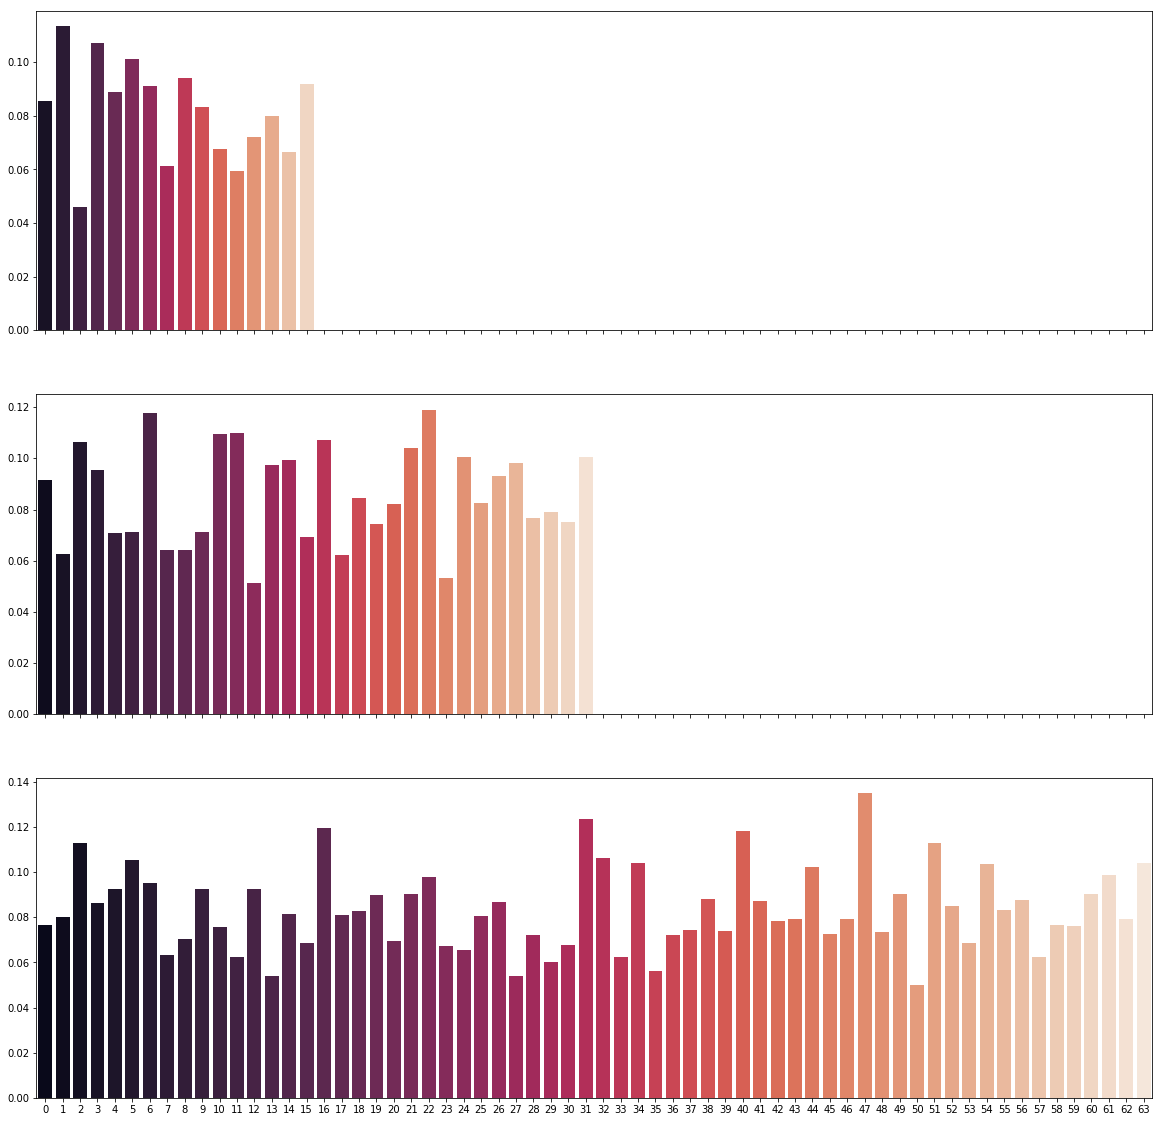

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20), sharex=True)
i = 19
sns.barplot(np.arange(16), test_log['16'][i][2].cpu().numpy(), palette="rocket", ax=ax1)
sns.barplot(np.arange(32), test_log['32'][i][2].cpu().numpy(), palette="rocket", ax=ax2)
sns.barplot(np.arange(64), test_log['64'][i][2].cpu().numpy(), palette="rocket", ax=ax3)

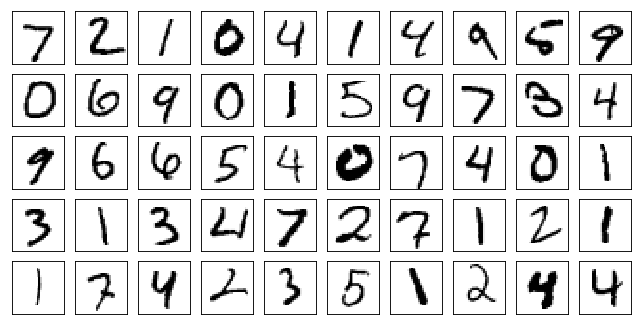

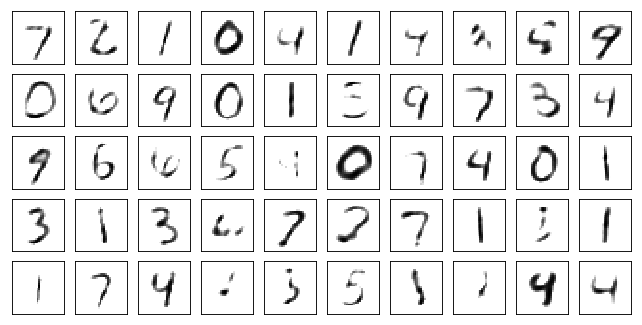

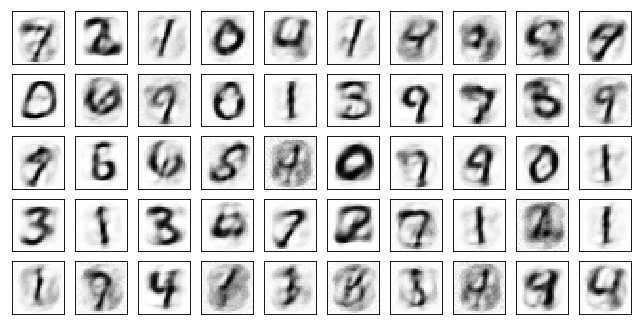

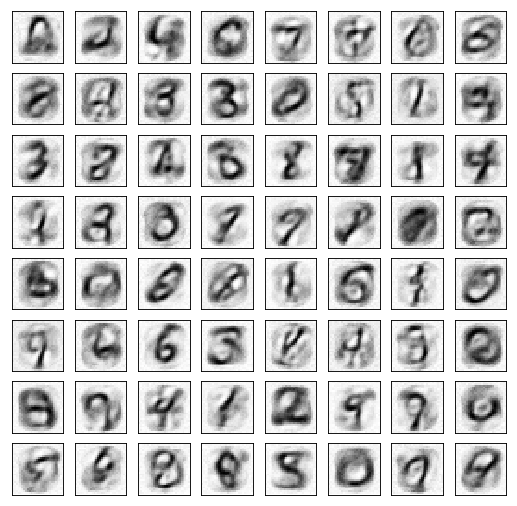

In [14]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))